# CNN model with Resudial Connection for classification of SVHN dataset

## Mount the Google Drive to Google Colab

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Change directory to data set folder

In [30]:
cd /content/gdrive/MyDrive/Datasets/

/content/gdrive/MyDrive/Datasets


Download the data sets


In [ ]:
!wget --no-check-certificate "http://ufldl.stanford.edu/housenumbers/train_32x32.mat" -O "train_32x32.mat"
!wget --no-check-certificate "http://ufldl.stanford.edu/housenumbers/test_32x32.mat" -O "test_32x32.mat"

--2021-06-24 19:37:22--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  14.0MB/s    in 6.0s    

2021-06-24 19:37:28 (28.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-06-24 19:37:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  53.2MB/s    in 1.2s    

2021-06-24 19:37:30 (53.2 MB/s) - ‘test_32x32.mat’ saved [64275384/64

## Load & visulize the data

In [49]:
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']


# X and y are numpy ndarrays

Get to know the dimensions of ndarrays

In [50]:
print("Shape of X_train is:", X_train.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_test is:", y_test.shape)

Shape of X_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of X_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)


Since we now know the structure of the data, we can  visulize our training images

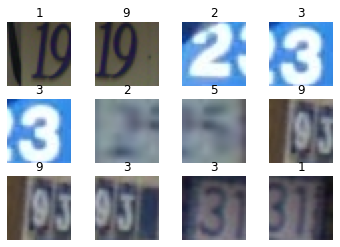

In [51]:
import matplotlib.pyplot as plt

%matplotlib inline

X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

start = 0

fig, ax = plt.subplots(3, 4)
for row in range(3):
    for col in range(4):
        ax[row, col].imshow(X_train[:,:,:,start+row*3+col])
        ax[row, col].axis('off')
        ax[row, col].set_title('{}'.format(y_train[start+row*3+col, 0]))
plt.show()

## Data preprocessing

Since TensorFlow requires the input shape to be (image_num, height, width, channel), we need to reshape our input data. 

In [52]:
import numpy as np

X_train = np.rollaxis(X_train, 3)
X_test = np.rollaxis(X_test, 3)

print("Shape of X_train is now:", X_train.shape)
print("Shape of X_test is now:", X_test.shape)

Shape of X_train is now: (73257, 32, 32, 3)
Shape of X_test is now: (26032, 32, 32, 3)


We also need to reduce the dimension of our output array to one.

In [53]:
y_train = y_train[:,0]
y_test = y_test[:,0]

print("Shape of y_train is now:", y_train.shape)
print("Shape of y_test is now:", y_test.shape)

Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)


From the plot we know our data labels digit '0' to '10', we need to change it to '0'.

In [54]:
y_train[y_train==10] = 0
y_test[y_test==10] = 0

print("labels of y_train are", np.unique(y_train[:]))
print("labels of y_test are", np.unique(y_test[:]))

labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]


### Gloabal Contrast Normalization 

In [55]:
def global_contrast_normalization(img, s, lmda, epsilon):
    #X = numpy.array(Image.open(filename))
    X = img
    # replacement for the loop
    X_average = np.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(X**2))

    X = s * X / max(contrast, epsilon)
    return X

In [56]:
for i in range(len(X_train[:])):
    img = X_train[i,:]
    X_train[i,:] = global_contrast_normalization(img, 1, 10, 0.000000001)
     

Finally we nomarlize our input data into range (0, 1)

In [57]:
X_train = X_train / 255
X_test = X_test / 255

## Build the model

In [76]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, add, Lambda, Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [94]:
in_img = Input(shape=(32,32,3))
out = Conv2D(32,(3,3),activation='relu')(in_img)
out1 = Conv2D(32,(3,3),padding='same', activation='relu')(out)
out2 = Conv2D(32,(3,3),padding='same', activation='relu')(out1)
# Resudial Connection
out2 = add([out1,out2])
out1 = out2

out = MaxPooling2D(2,2)(out2)

# Dropout layer
out = Dropout(0.3)(out)
out3 = Conv2D(64,(3,3),padding='same',activation='relu')(out)
out4 = Conv2D(64,(3,3),padding='same',activation='relu')(out3)
# Resudial Connection
out4 = add([out3,out4])
out3 = out4
out = MaxPooling2D(2,2)(out4)
# Dropout layer
out = Dropout(0.3)(out)

out = Flatten()(out)
out = Dense(units=512, activation='relu')(out)
# Dropout layer
out = Dropout(0.3)(out)
out = Dense(units=16, activation='relu')(out)
out = Dense(units=10, activation='softmax')(out)

model = Model(inputs=in_img, outputs=out)

# get a summary of our built model
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 30, 30, 32)   896         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 30, 30, 32)   9248        conv2d_121[0][0]                 
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 30, 30, 32)   9248        conv2d_122[0][0]                 
___________________________________________________________________________________________

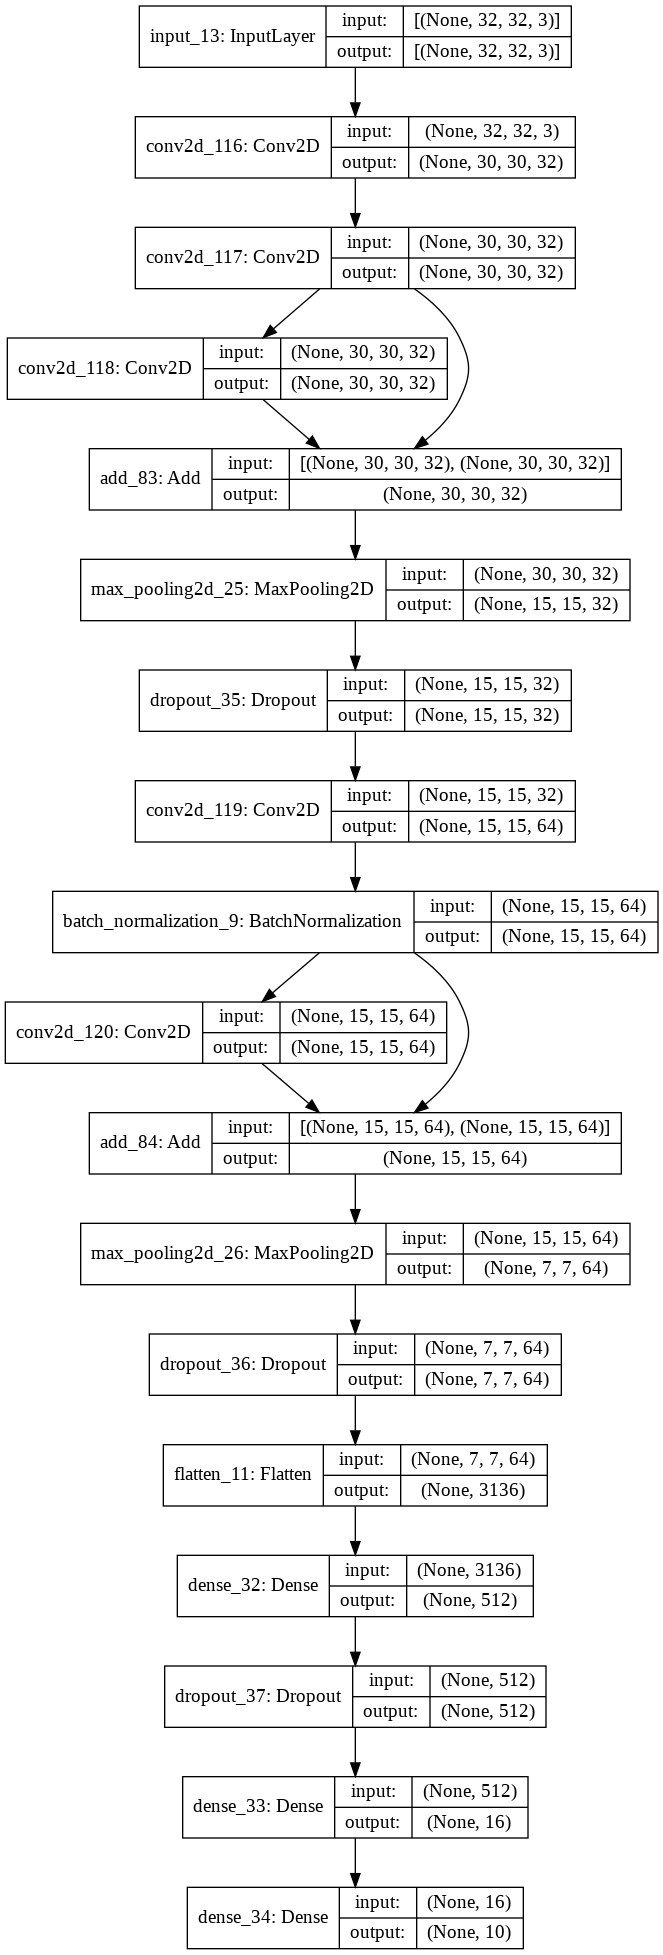

In [91]:
# Plot Model
plot_model(model, show_shapes=True, show_layer_names=True)

## Configure training parameters

In [95]:
# define the optimizer, loss function and metrics for the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model
It is incomplete training because my GPU utilization time out. Below cell shows the complete training

In [ ]:
# Model training
model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
1832/1832 - 319s - loss: 1.0865 - accuracy: 0.6393 - val_loss: 0.7226 - val_accuracy: 0.7663
Epoch 2/10


In [ ]:
 # Model training
model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
1832/1832 - 8s - loss: 0.8999 - accuracy: 0.7073 - val_loss: 0.4151 - val_accuracy: 0.8754
Epoch 2/10
1832/1832 - 6s - loss: 0.4601 - accuracy: 0.8605 - val_loss: 0.3370 - val_accuracy: 0.8996
Epoch 3/10
1832/1832 - 7s - loss: 0.3927 - accuracy: 0.8807 - val_loss: 0.3288 - val_accuracy: 0.9019
Epoch 4/10
1832/1832 - 7s - loss: 0.3601 - accuracy: 0.8907 - val_loss: 0.3169 - val_accuracy: 0.9056
Epoch 5/10
1832/1832 - 7s - loss: 0.3349 - accuracy: 0.8982 - val_loss: 0.2935 - val_accuracy: 0.9176
Epoch 6/10
1832/1832 - 7s - loss: 0.3082 - accuracy: 0.9069 - val_loss: 0.2956 - val_accuracy: 0.9161
Epoch 7/10
1832/1832 - 7s - loss: 0.2906 - accuracy: 0.9112 - val_loss: 0.2801 - val_accuracy: 0.9227
Epoch 8/10
1832/1832 - 7s - loss: 0.2813 - accuracy: 0.9145 - val_loss: 0.2606 - val_accuracy: 0.9278
Epoch 9/10
1832/1832 - 6s - loss: 0.2634 - accuracy: 0.9185 - val_loss: 0.2658 - val_accuracy: 0.9264
Epoch 10/10
1832/1832 - 7s - loss: 0.2571 - accuracy: 0.9207 - val_loss: 0.2727 - 

## Model evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Model accuracy on test data is: {:6.3f}%".format(100 * acc))

814/814 [==============================] - 2s 3ms/step - loss: 2.2236 - accuracy: 0.1959
Model accuracy on test data is: 19.587%
